In [586]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.sparse import diags
from scipy.fftpack import fft,ifft
from time import sleep,time
from scipy import sparse as sparse
from scipy.sparse import linalg as ln

from ipycanvas import MultiCanvas, hold_canvas,Canvas


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# default values for plotting
plt.rcParams.update({'font.size': 16,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Split Step Method

If we look at bit closer at the two Schrödinger equations above, we recognize that there is some symmetry in the two Schrödinger equations, which we can use to calculate the time-dependence of the wave function. This type of method is called the split step method.

We may substitute in the right side of the position Schrödinger equation 

\begin{equation}
\hat{D}=\frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}
\end{equation}

and 

\begin{equation}
\hat{N}=V(x,t) 
\end{equation}

such that 

$$
i\hbar\frac{\partial \Psi(x,t)}{\partial t} = [\hat{D}+\hat{N}]\Psi
$$

with the solution 

$$
\Psi(x,t)=e^{-i(\hat{D}+\hat{N})t/\hbar}\Psi(x,0)
$$


If we only make a small timestep $dt$, we can write the latter equation also as

$$
\Psi(x,t+dt)=e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar} \Psi(x,t)
$$


We may now turn to momentum space by taking the Fourier transform $F$

$$
\tilde{\Psi}(k,t+dt)=F\left [e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

What we know now from the momentum Schrödinger equation is that the operator $\hat{D}$ will just turn into a multiplication with $\hbar k^2/2m$ in momentum space and therefore 

$$
\tilde{\Psi}(k,t+dt)=e^{i\frac{\hbar k^2}{2m}dt}F\left [e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

Thus if we just do the inverse Fourier transform of that, we obtain

$$
\Psi(x,t+dt)=F^{-1}\left [ e^{i\frac{\hbar k^2}{2m}dt} F\left [e^{-i\hat{N}dt/\hbar}\Psi(x,t) \right ]  \right]
$$


This is the receipe we want to solve the time dependent Schrödinger equation.

In [587]:
hbar=1
m=1

In [588]:
def gauss_x(x, sigma, x0, k0):
    return (np.exp(-0.5 * ((x - x0)/ sigma) ** 2 + 1j * x * k0)/(sigma * np.sqrt(np.pi)))

In [589]:
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

In [590]:
dt = 0.005
N_steps = 50
t_max = 120
frames = int(t_max / float(N_steps * dt))

In [606]:
V0 = 1
L = hbar / np.sqrt(2 * V0)
a = 3 * L
V_x =V0*(np.heaviside(x,1)-np.heaviside(x-a,1))
V_x[np.abs(x) > 98] = 1e6

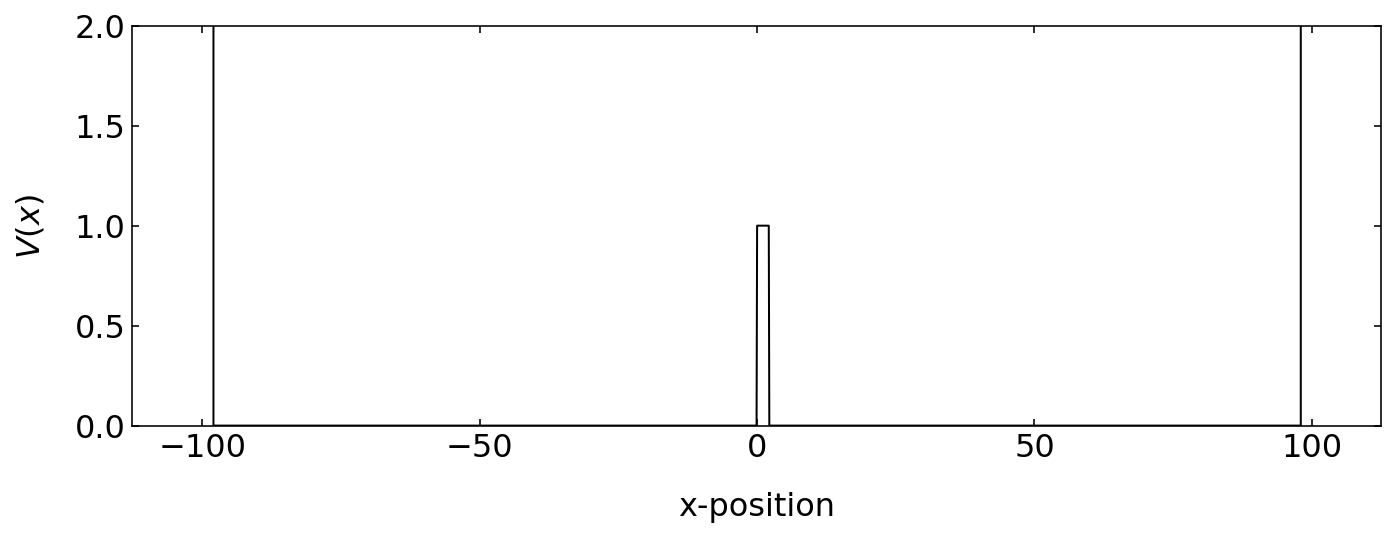

In [607]:
plt.figure(figsize=(10,4))
plt.plot(x,V_x,'k')
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel('$V(x)$')
plt.tight_layout()
plt.show()

In [608]:
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)
k0 = p0 / hbar
v0 = p0 /m
x0=-50
psi_x0 = gauss_x(x, d, x0, k0)


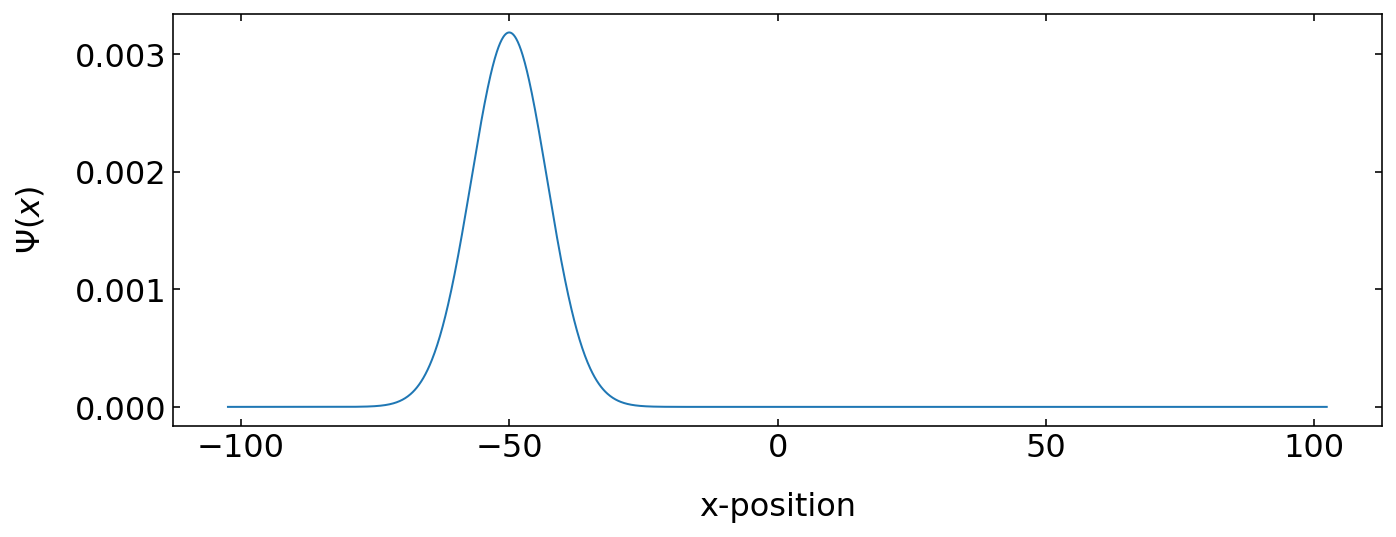

In [609]:

plt.figure(figsize=(10,4))
plt.plot(x,np.abs(psi_x0)**2)
plt.xlabel('x-position')
plt.ylabel('$\Psi(x)$')
plt.tight_layout()
plt.show()

In [631]:
N=len(x)
dx=x[1]-x[0]
k0=-np.pi/dx
dk = 2 * np.pi / (N * dx)
k = k0 + dk * np.arange(N)

In [632]:
psi_x=psi_x0.copy()

psi_modx=psi_x*np.exp(-1j * k[0] * x)* dx / np.sqrt(2 * np.pi)
phase_x=np.exp(-1j*V_x*dt/hbar)
phase_k=np.exp(-1j*hbar*k**2/m*dt)

In [633]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,V_x,'k')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x,np.abs(psi_modx)**2,'g')[0]

plt.close() 

In [634]:
## setup the canvas
canvas = Canvas(width=800, height=380,sync_image_data=False)
display(canvas)

Canvas(height=380, width=800)

In [635]:
for i in range(10000000):
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    for j in range(100):
        tmp=ifft(phase_k*fft(psi_modx*phase_x))
        psi_modx=tmp
    points.set_data(x,1e5*np.abs(psi_modx)**2)

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())

    
    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.01)

KeyboardInterrupt: 

## Old Split Step Method

If we look at bit closer at the two Schrödinger equations above, we recognize that there is some symmetry in the two Schrödinger equations, which we can use to calculate the time-dependence of the wave function. This type of method is called the split step method.

We may substitute in the right side of the position Schrödinger equation 

\begin{equation}
\hat{D}=\frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}
\end{equation}

and 

\begin{equation}
\hat{N}=V(x,t) 
\end{equation}

such that 

$$
i\hbar\frac{\partial \Psi(x,t)}{\partial t} = [\hat{D}+\hat{N}]\Psi
$$

with the solution 

$$
\Psi(x,t)=e^{-i(\hat{D}+\hat{N})t/\hbar}\Psi(x,0)
$$


If we only make a small timestep $dt$, we can write the latter equation also as

$$
\Psi(x,t+dt)=e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar} \Psi(x,t)
$$


We may now turn to momentum space by taking the Fourier transform $F$

$$
\tilde{\Psi}(k,t+dt)=F\left [e^{-i\hat{D}dt/\hbar}e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

What we know now from the momentum Schrödinger equation is that the operator $\hat{D}$ will just turn into a multiplication with $k^2$ in momentum space and therefore 

$$
\tilde{\Psi}(k,t+dt)=e^{ik^2dt}F\left [e^{-i\hat{N}dt/\hbar}\right ]\tilde{\Psi}(k,t)
$$

Thus if we just do the inverse Fourier transform of that, we obtain

$$
\Psi(x,t+dt)=F^{-1}\left [ e^{ik^2dt} F\left [e^{-i\hat{N}dt/\hbar}\Psi(x,t) \right ]  \right]
$$


This is the receipe we want to solve the time dependent Schrödinger equation.

### Setup the simulation

While we did use in the previous calculations a sum over many plane waves to specify a Gaussian wave packet, we use the analytical version

$$
\Psi(x)=\frac{1}{\sqrt{\pi}\sigma}e^{-\frac{(x-x_{0})^2}{2\sigma^2}+ik_{0}x}
$$

and the corresponding momentum space wavefunction

$$
\tilde{\Psi}(k)=\frac{1}{\sqrt{\pi}\sigma}e^{-\frac{(k-k_{0})^2}{2\sigma^2}-i(k-k_{0})x}
$$

for the Gaussian wavepacket.


In [461]:
def gauss_x(x, sigma, x0, k0):
    return (np.exp(-0.5 * ((x - x0)/ sigma) ** 2 + 1j * x * k0)/(sigma * np.sqrt(np.pi)))

def gauss_k(k,sigma,x0,k0):
    return (np.exp(-0.5 * (a * (k - k0)) ** 2 - 1j * (k - k0) * x0)/(sigma * np.sqrt(np.pi)))

We also need to setup some fundamental parameters.

In [462]:
hbar = 1.0   # planck's constant
m = 1.9      # particle mass

We define our spatial domain with an even number of data points, which is important for the `FFT` method.

In [463]:
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

We will also define the temporal domain to be covered by our simulations

In [464]:
dt = 0.01
N_steps = 50
t_max = 120
frames = int(t_max / float(N_steps * dt))

Our potential energy landscape shall consists of very high boundaries at the edges and a barrier in the center.

In [465]:
V0 = 0.7
L = hbar / np.sqrt(2 * m * V0)
a = 4 * L
V_x =V0*(np.heaviside(x,1)-np.heaviside(x-a,1))
V_x[np.abs(x) > 98] = 1e6


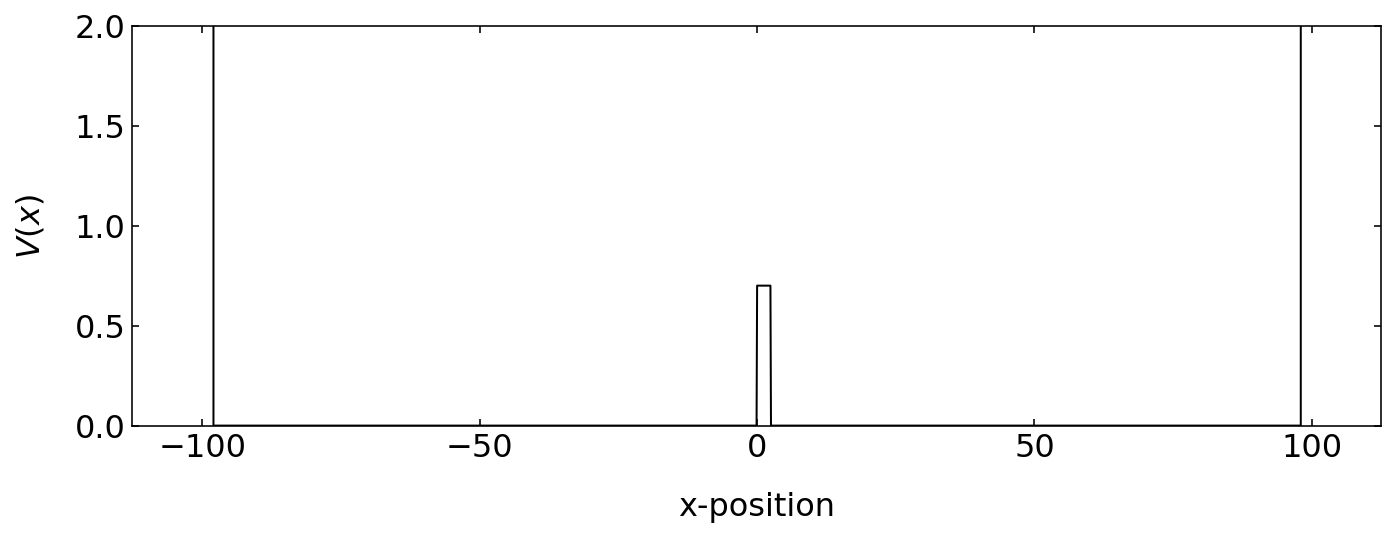

In [466]:
plt.figure(figsize=(10,4))
plt.plot(x,V_x,'k')
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel('$V(x)$')
plt.tight_layout()
plt.show()

Finally, we want to specify our initial wavepacket

In [467]:
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)
k0 = p0 / hbar
v0 = p0 / m
psi_x0 = gauss_x(x, d, x0, k0)

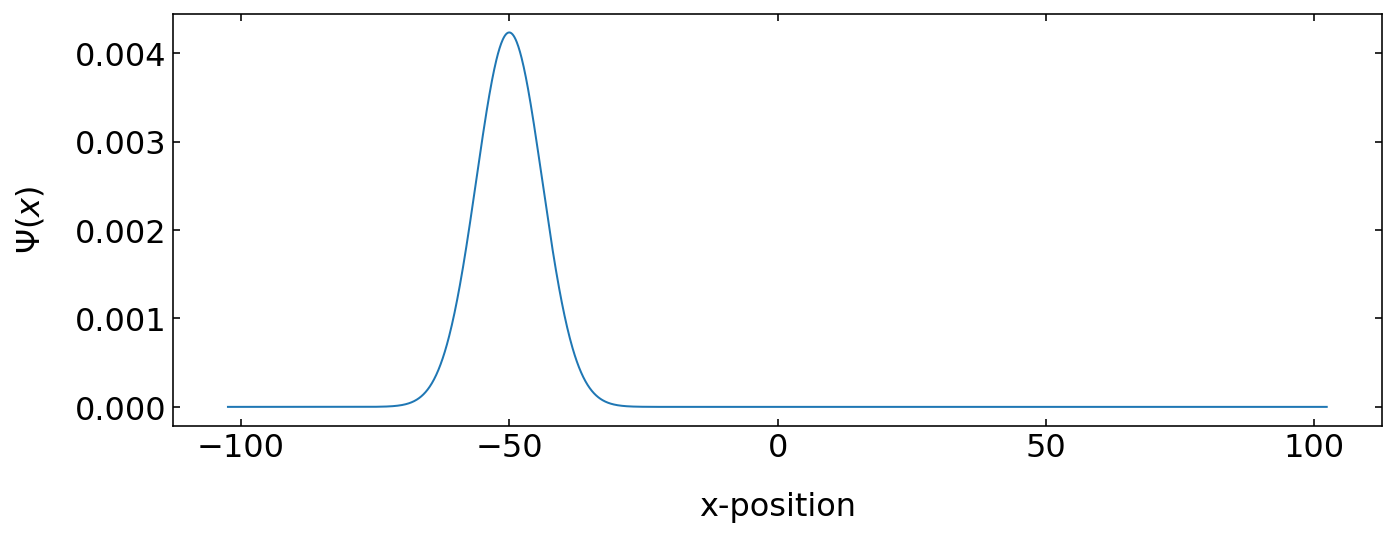

In [468]:

plt.figure(figsize=(10,4))
plt.plot(x,np.abs(psi_x0)**2)
plt.xlabel('x-position')
plt.ylabel('$\Psi(x)$')
plt.tight_layout()
plt.show()

In [469]:
class Schrodinger(object):
    """
    Class which implements a numerical solution of the time-dependent
    Schrodinger equation for an arbitrary potential
    """
    def __init__(self, x, psi_x0, V_x,
                 k0 = None, hbar=1, m=1, t0=0.0):

        # Validation of array inputs
        self.x, psi_x0, self.V_x = map(np.asarray, (x, psi_x0, V_x))

        # Set internal parameters
        self.hbar,self.m,self.t,self.k0 = hbar,m,t0,k0
        self.N= len(x)
        self.dx = x[1]-x[0]
        self.dk = 2 * np.pi / (self.N * self.dx)

        
        
        self.k = self.k0 + self.dk * np.arange(self.N)

        self.psi_x = psi_x0
        self.compute_k_from_x()

        # variables which hold steps in evolution of the
        self.x_evolve_half = None
        self.x_evolve = None
        self.k_evolve = None
        self.dt_ = None

        # attributes used for dynamic plotting
        self.psi_x_line = None
        self.psi_k_line = None
        self.V_x_line = None

    def _set_psi_x(self, psi_x):
        self.psi_mod_x = (psi_x * np.exp(-1j * self.k[0] * self.x)
                          * self.dx / np.sqrt(2 * np.pi))

    def _get_psi_x(self):
        return (self.psi_mod_x * np.exp(1j * self.k[0] * self.x)
                * np.sqrt(2 * np.pi) / self.dx)

    def _set_psi_k(self, psi_k):
        self.psi_mod_k = psi_k * np.exp(1j * self.x[0]
                                        * self.dk * np.arange(self.N))

    def _get_psi_k(self):
        return self.psi_mod_k * np.exp(-1j * self.x[0] * 
                                        self.dk * np.arange(self.N))
    
    def _get_dt(self):
        return self.dt_

    def _set_dt(self, dt):
        if dt != self.dt_:
            self.dt_ = dt
            self.x_evolve_half = np.exp(-0.5 * 1j * self.V_x
                                         / self.hbar * dt )
            self.x_evolve = self.x_evolve_half * self.x_evolve_half
            self.k_evolve = np.exp(-0.5 * 1j * self.hbar /
                                    self.m * (self.k * self.k) * dt)
    
    psi_x = property(_get_psi_x, _set_psi_x)
    psi_k = property(_get_psi_k, _set_psi_k)
    dt = property(_get_dt, _set_dt)

    def compute_k_from_x(self):
        self.psi_mod_k = fft(self.psi_mod_x)

    def compute_x_from_k(self):
        self.psi_mod_x = ifft(self.psi_mod_k)

    def time_step(self, dt, Nsteps = 1):
        self.dt = dt

        if Nsteps > 0:
            self.psi_mod_x *= self.x_evolve_half

        for i in range(Nsteps - 1):
            self.compute_k_from_x()
            self.psi_mod_k *= self.k_evolve
            self.compute_x_from_k()
            self.psi_mod_x *= self.x_evolve

        self.compute_k_from_x()
        self.psi_mod_k *= self.k_evolve

        self.compute_x_from_k()
        self.psi_mod_x *= self.x_evolve_half

        self.compute_k_from_x()

        self.t += dt * Nsteps



In [470]:
## setup the canvas
canvas = Canvas(width=800, height=380,sync_image_data=False)
display(canvas)

Canvas(height=380, width=800)

In [471]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.xlim(-100,100)
plt.ylim(0,2)
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.plot(x,V_x,'k')
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(S.x,8*np.abs(S.psi_x),'g')[0]

plt.close() 

In [472]:
# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,psi_x0=psi_x0,V_x=V_x,hbar=hbar,m=m,k0=-20)

In [473]:
for i in range(10000000):
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    S.time_step(dt, 200)
    points.set_data(S.x,8*np.abs(S.psi_x))

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())

    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.01)

KeyboardInterrupt: 